In [1]:
import os
import numpy as np
import pandas as pd

import tempfile

from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc

from deepchem.utils import download_url, load_from_disk

from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.rdkit_utils import load_complex
from deepchem.utils.geometry_utils import compute_pairwise_distances

from deepchem.utils.evaluate import Evaluator
import pandas as pd

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
    print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]

In [3]:
from openmm.app import PDBFile
from pdbfixer import PDBFixer

#from deepchem.utils.vina_utils import prepare_inputs
from deepchem.utils.docking_utils import prepare_inputs
from tqdm.auto import tqdm
import itertools
import os
import sys
sys.path.append(os.getcwd() + '/..')
from pyDowker.DowkerComplex import DowkerComplex
from pyDowker.TwoParameterUtils import grid_ECP
from DowkerFeaturizer import DowkerFeaturizer, DowkerBifiFeaturizer, DowkerStackedBettiFeaturizer
from pyrivet import rivet
import xgboost as xgb

In [4]:
# consider one protein-ligand complex for visualization
pdbid = raw_dataset['pdb_id'].iloc[0]
ligand = raw_dataset['smiles'].iloc[0]

In [5]:
%%time
fixer = PDBFixer(pdbid=pdbid)
PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

p, m = None, None
# fix protein, optimize ligand geometry, and sanitize molecules
try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand)
except:
    print('%s failed PDB fixing' % (pdbid)) 

if p and m:  # protein and molecule are readable by RDKit
    print(pdbid, p.GetNumAtoms())
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

2d3u 8690
CPU times: user 12.8 s, sys: 97.1 ms, total: 12.9 s
Wall time: 13.4 s


[16:32:12] WARNING: not removing hydrogen atom without neighbors
[16:32:12] WARNING: not removing hydrogen atom without neighbors
[16:32:16] UFFTYPER: Unrecognized atom type: S_5+4 (7)


In [6]:
pdbids = raw_dataset['pdb_id'].values
ligand_smiles = raw_dataset['smiles'].values

In [7]:
%%time
for (pdbid, ligand) in zip(pdbids, ligand_smiles):
    fixer = PDBFixer(url='https://files.rcsb.org/download/%s.pdb' % (pdbid))
    PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))
  
    p, m = None, None
    # skip pdb fixing for speed
    try:
        p, m = prepare_inputs('%s.pdb' % (pdbid), ligand, replace_nonstandard_residues=False,
                          remove_heterogens=False, remove_water=False,
                          add_hydrogens=False)
    except:
        print('%s failed sanitization' % (pdbid)) 

    if p and m:  # protein and molecule are readable by RDKit
        Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
        Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

[16:32:18] UFFTYPER: Unrecognized atom type: S_5+4 (7)
[16:32:30] UFFTYPER: Warning: hybridization set to SP3 for atom 17
[16:32:31] UFFTYPER: Warning: hybridization set to SP3 for atom 6
[16:32:33] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:32:33] UFFTYPER: Unrecognized atom type: S_5+4 (21)
[16:32:44] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[16:32:51] UFFTYPER: Warning: hybridization set to SP3 for atom 19
[16:32:54] UFFTYPER: Warning: hybridization set to SP3 for atom 29
[16:33:13] UFFTYPER: Unrecognized atom type: S_5+4 (39)
[16:33:35] UFFTYPER: Warning: hybridization set to SP3 for atom 33
[16:33:52] UFFTYPER: Unrecognized atom type: S_5+4 (11)
[16:33:56] UFFTYPER: Unrecognized atom type: S_5+4 (47)
[16:34:03] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[16:34:13] UFFTYPER: Warning: hybridization set to SP3 for atom 6
[16:34:18] UFFTYPER: Unrecognized atom type: S_5+4 (47)
[16:34:25] UFFTYPER: Unrecognized atom type: S_5+4 (28)
[16:34:33] UFFTYPER: 

1hfs failed sanitization


[16:37:39] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[16:37:51] Explicit valence for atom # 1800 C, 5, is greater than permitted
[16:37:51] UFFTYPER: Unrecognized atom type: S_5+4 (11)
[16:37:52] UFFTYPER: Warning: hybridization set to SP3 for atom 11
[16:38:04] UFFTYPER: Warning: hybridization set to SP3 for atom 9
[16:38:04] UFFTYPER: Warning: hybridization set to SP3 for atom 23
[16:38:05] UFFTYPER: Warning: hybridization set to SP3 for atom 8
[16:38:05] UFFTYPER: Warning: hybridization set to SP3 for atom 12
[16:38:05] UFFTYPER: Warning: hybridization set to SP3 for atom 34
[16:38:05] UFFTYPER: Warning: hybridization set to SP3 for atom 41


CPU times: user 1min 51s, sys: 906 ms, total: 1min 52s
Wall time: 5min 50s


In [8]:
proteins = [f for f in os.listdir('.') if len(f) == 8 and f.endswith('.pdb')]
ligands = [f for f in os.listdir('.') if f.startswith('ligand') and f.endswith('.pdb')]

In [9]:
# Handle failed sanitizations
failures = set([f[:-4] for f in proteins]) - set([f[7:-4] for f in ligands])
for pdbid in failures:
    proteins.remove(pdbid + '.pdb')

In [10]:
len(proteins), len(ligands)

(190, 190)

In [11]:
pdbids = [f[:-4] for f in proteins]
small_dataset = raw_dataset[raw_dataset['pdb_id'].isin(pdbids)]
labels = small_dataset.label

In [12]:
proteins = [pdbid+'.pdb' for pdbid in pdbids]
ligands = ['ligand_'+pdbid+'.pdb' for pdbid in pdbids]
proteins.sort()
ligands.sort()
labels = [small_dataset.label[small_dataset['pdb_id'][small_dataset['pdb_id']==pdbid].index.to_list()[0]] for pdbid in pdbids]

In [13]:
list(zip(ligands,proteins))

[('ligand_10gs.pdb', '10gs.pdb'),
 ('ligand_1a30.pdb', '1a30.pdb'),
 ('ligand_1bcu.pdb', '1bcu.pdb'),
 ('ligand_1e66.pdb', '1e66.pdb'),
 ('ligand_1f8b.pdb', '1f8b.pdb'),
 ('ligand_1f8c.pdb', '1f8c.pdb'),
 ('ligand_1f8d.pdb', '1f8d.pdb'),
 ('ligand_1gpk.pdb', '1gpk.pdb'),
 ('ligand_1h23.pdb', '1h23.pdb'),
 ('ligand_1hnn.pdb', '1hnn.pdb'),
 ('ligand_1igj.pdb', '1igj.pdb'),
 ('ligand_1jyq.pdb', '1jyq.pdb'),
 ('ligand_1kel.pdb', '1kel.pdb'),
 ('ligand_1lbk.pdb', '1lbk.pdb'),
 ('ligand_1lol.pdb', '1lol.pdb'),
 ('ligand_1loq.pdb', '1loq.pdb'),
 ('ligand_1lor.pdb', '1lor.pdb'),
 ('ligand_1mq6.pdb', '1mq6.pdb'),
 ('ligand_1n1m.pdb', '1n1m.pdb'),
 ('ligand_1n2v.pdb', '1n2v.pdb'),
 ('ligand_1nvq.pdb', '1nvq.pdb'),
 ('ligand_1o3f.pdb', '1o3f.pdb'),
 ('ligand_1o5b.pdb', '1o5b.pdb'),
 ('ligand_1os0.pdb', '1os0.pdb'),
 ('ligand_1oyt.pdb', '1oyt.pdb'),
 ('ligand_1p1q.pdb', '1p1q.pdb'),
 ('ligand_1ps3.pdb', '1ps3.pdb'),
 ('ligand_1q8t.pdb', '1q8t.pdb'),
 ('ligand_1q8u.pdb', '1q8u.pdb'),
 ('ligand_1qi0

In [14]:
fp_featurizer = dc.feat.ContactCircularFingerprint(size=2048)

In [15]:
features = fp_featurizer.featurize(zip(ligands, proteins))


[16:09:56] Explicit valence for atom # 2208 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)[C@@H](N=C(O)[C@H](CC1CCC(O[PH](O)(O)O)CC1)NC(=O)[

In [16]:
train_scores = []
test_scores = []

for seed in range(0,100):
    #seed = 42 # Set a random seed to get stable results

    dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
    train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=seed)
    sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
    sklearn_model.random_state = seed
    model = dc.models.SklearnModel(sklearn_model)
    model.fit(train_dataset)

    metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

    evaluator = Evaluator(model, train_dataset, [])
    train_r2score = evaluator.compute_model_performance([metric])
    #print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))
    train_scores.append(train_r2score['pearson_r2_score'])
    
    
    evaluator = Evaluator(model, test_dataset, [])
    test_r2score = evaluator.compute_model_performance([metric])
    #print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))
    test_scores.append(test_r2score['pearson_r2_score'])

In [17]:
print("avg RF Train R^2:", np.mean(train_scores),"\pm",np.std(train_scores))
print("avg RF Test R^2:", np.mean(test_scores),"\pm",np.std(test_scores))

avg RF Train R^2: 0.41241129697369955 \pm 0.025465177883953184
avg RF Test R^2: 0.020733395065644585 \pm 0.02669054781580462


In [14]:


dgm0 = []
dgm1 = []

for datapoint in tqdm(zip(ligands,proteins)):
    fragments = load_complex(datapoint, add_hydrogens=False)
    for (frag1, frag2) in itertools.combinations(fragments, 2):
        ligand_atoms = np.array([a.GetSymbol() for a in frag1[1].GetAtoms()])
        protein_atoms = np.array([a.GetSymbol() for a in frag2[1].GetAtoms()])
        dist = compute_pairwise_distances(frag1[0],frag2[0])
        local_dgm0 = []
        local_dgm1 = []
        for la in ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I']:
            for pa in ['C', 'N', 'O', 'S']:
                local_dist = dist[ligand_atoms==la,:][:,protein_atoms==pa]
                if local_dist.size>0:
                    dowker = DowkerComplex(local_dist,max_filtration=4.5)
                    st = dowker.create_simplex_tree(max_dimension=2,m=1, filtration="Sublevel")
                    st.compute_persistence()
                    local_dgm0.append(st.persistence_intervals_in_dimension(0))
                    local_dgm1.append(st.persistence_intervals_in_dimension(1))
                else:
                    local_dgm0.append(np.empty((0,2)))
                    local_dgm1.append(np.empty((0,2)))
        dgm0.append(local_dgm0)
        dgm1.append(local_dgm1)

0it [00:00, ?it/s]

[12:03:34] Explicit valence for atom # 679 C, 5, is greater than permitted
Mol CCC1C[C@@H]2CC3NC4CC(Cl)CCC4C(N)C3[C@H](C1)C2.CCCC[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C(C)C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CCC2=OO2)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](C(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(N)=

In [15]:
from gudhi.representations import BettiCurve,Landscape
bc = Landscape(num_landscapes = 4, resolution=1024, sample_range = (0,100))
#bc = BettiCurve(predefined_grid=np.linspace(0,100,2048))

bc0 = np.array([np.concatenate(bc.fit_transform(d)) for d in dgm0])
bc1 = np.array([np.concatenate(bc.fit_transform(d)) for d in dgm1])
vectors = bc1#np.concatenate([bc0,bc1],axis=1)

/home/niklas/anaconda3/envs/Graphs/lib/python3.9/site-packages/gudhi/representations/vector_methods.py:200: RuntimeWarning: invalid value encountered in subtract
  tent_functions = np.maximum(heights[None, :] - np.abs(x_values[:, None] - midpoints[None, :]), 0)


In [16]:
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
train_scores = []
test_scores = []

for seed in tqdm(range(0,100)):
    #seed = 42 # Set a random seed to get stable results

    dataset = dc.data.NumpyDataset(X=vectors, y=labels, ids=pdbids)
    train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=seed)
    #sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
    sklearn_model = xgb.XGBRegressor()
    sklearn_model.random_state = seed
    model = dc.models.SklearnModel(sklearn_model)
    model.fit(train_dataset)

    metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

    evaluator = Evaluator(model, train_dataset, [])
    train_r2score = evaluator.compute_model_performance([metric])
    #print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))
    train_scores.append(train_r2score['pearson_r2_score'])
    
    
    evaluator = Evaluator(model, test_dataset, [])
    test_r2score = evaluator.compute_model_performance([metric])
    #print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))
    test_scores.append(test_r2score['pearson_r2_score'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
print("avg RF Train R^2:", np.mean(train_scores),"\pm",np.std(train_scores))
print("avg RF Test R^2:", np.mean(test_scores),"\pm",np.std(test_scores))

avg RF Train R^2: 0.32614200412493843 \pm 0.030714152721811633
avg RF Test R^2: 0.02323734431540558 \pm 0.029033867564898667


In [14]:

mn_featurizer = DowkerFeaturizer(m=10,size=1024)
features = mn_featurizer.featurize(zip(ligands, proteins))

train_scores = []
test_scores = []

for seed in range(0,100):
    #seed = 42 # Set a random seed to get stable results

    dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
    train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=seed)
    #sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
    sklearn_model = xgb.XGBRegressor()
    sklearn_model.random_state = seed
    model = dc.models.SklearnModel(sklearn_model)
    model.fit(train_dataset)

    metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

    evaluator = Evaluator(model, train_dataset, [])
    train_r2score = evaluator.compute_model_performance([metric])
    #print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))
    train_scores.append(train_r2score['pearson_r2_score'])
    
    
    evaluator = Evaluator(model, test_dataset, [])
    test_r2score = evaluator.compute_model_performance([metric])
    #print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))
    test_scores.append(test_r2score['pearson_r2_score'])
    
print("avg RF Train R^2:", np.mean(train_scores),"\pm",np.std(train_scores))
print("avg RF Test R^2:", np.mean(test_scores),"\pm",np.std(test_scores))

[14:43:30] Explicit valence for atom # 681 O, 3, is greater than permitted
Mol CCC1C[C@@H]2CC3NC4CC(Cl)CCC4C(N)C3[C@H](C1)C2.CCCC[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[

avg RF Train R^2: 0.9990822541408514 \pm 0.0008245640283337222
avg RF Test R^2: 0.023971101544941913 \pm 0.030350324161775005


In [16]:
datapoint = list(zip(ligands,proteins))[0]
bifi_featurizer = DowkerStackedBettiFeaturizer(m_max=8,size=128, cutoff=4.5)
#from DowkerFeaturizer import featurize_contacts_dowker_bifi
#features = featurize_contacts_dowker_bifi(*load_complex(datapoint, add_hydrogens=False))
#frag1, frag2 = load_complex(datapoint, add_hydrogens=False)
my_features = bifi_featurizer._featurize(datapoint)

In [17]:
print(datapoint)
print(np.sum(my_features))

('ligand_10gs.pdb', '10gs.pdb')
8435


In [17]:

bifi_featurizer = DowkerBifiFeaturizer(m_max=10,size=1024)
bifi_features = bifi_featurizer.featurize(zip(ligands, proteins))

train_scores = []
test_scores = []

for seed in tqdm(range(0,100)):
    #seed = 42 # Set a random seed to get stable results

    dataset = dc.data.NumpyDataset(X=bifi_features, y=labels, ids=pdbids)
    train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=seed)
    sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
    sklearn_model.random_state = seed
    model = dc.models.SklearnModel(sklearn_model)
    model.fit(train_dataset)

    metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

    evaluator = Evaluator(model, train_dataset, [])
    train_r2score = evaluator.compute_model_performance([metric])
    #print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))
    train_scores.append(train_r2score['pearson_r2_score'])
    
    
    evaluator = Evaluator(model, test_dataset, [])
    test_r2score = evaluator.compute_model_performance([metric])
    #print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))
    test_scores.append(test_r2score['pearson_r2_score'])
    
print("avg RF Train R^2:", np.mean(train_scores),"\pm",np.std(train_scores))
print("avg RF Test R^2:", np.mean(test_scores),"\pm",np.std(test_scores))

[14:57:17] Explicit valence for atom # 680 O, 3, is greater than permitted
Mol CCC1C[C@@H]2CC3NC4CC(Cl)CCC4C(N)C3[C@H](C1)C2.CCCC[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC1=OO1)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[

  0%|          | 0/100 [00:00<?, ?it/s]

avg RF Train R^2: 0.9454202791084311 \pm 0.0063292198170526075
avg RF Test R^2: 0.024307283584400676 \pm 0.040073849451204874


In [18]:
print("avg RF Train R^2:", np.mean(train_scores),"\pm",np.std(train_scores))
print("avg RF Test R^2:", np.mean(test_scores),"\pm",np.std(test_scores))

avg RF Train R^2: 0.9454202791084311 \pm 0.0063292198170526075
avg RF Test R^2: 0.024307283584400676 \pm 0.040073849451204874


# Refined Dataset

In [ ]:
# Uncomment to featurize all of PDBBind's "refined" set
mn_featurizer = DowkerFeaturizer(m=1,size=1024)
pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind(
     featurizer=mn_featurizer, set_name="refined", reload=True,
     data_dir='pdbbind_data', save_dir='pdbbind_data')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

from deepchem.utils.evaluate import Evaluator
import pandas as pd
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
#sklearn_model = xgb.XGBRegressor()
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

In [ ]:
test_r2score

In [ ]:
# Uncomment to featurize all of PDBBind's "refined" set
bifi_featurizer = DowkerStackedBettiFeaturizer(m_max=12,size=1024)
pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind(
     featurizer=bifi_featurizer, set_name="refined", reload=True,
     data_dir='pdbbind_data', save_dir='pdbbind_data')

[18:22:20] Explicit valence for atom # 61 O, 3, is greater than permitted
Mol O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O=C[C@@H]1CCCN1.[H]NCC(=O)N([H])[C@@H](CO[H])C(=O)N([H])[C@H](C(=O)N([H])[C@@H](C)C(=O)N([H])CC(=O)N([H])[C@H](C=O)CC1=CC=CC=C1)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C(=O)N([H])[C@]1(CCC(=O)O)OC1=O)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C=O)CO[H].[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])CC(=O)N1CCC[C@H]1C(=O)N([H])[C@@H](CCC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)N([H])CC=O.[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC(=O)N([H])[H].[H]N[C@@H](CC(C)C)C(=O)N([H])[C@H](C(=O)N([H])[C@H](C(=O)N([H])[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC1=CC=C(O[H])C=C1)[C@@H](C)CC)[C@@H](C)O[H].[H]N[C@@H](CC1=CC=C(O[H])C=C1)C(=O)N([H])[C@H](C=O)[C@@H](C)O[H].[H]N[C@@H](CCCN([H])C(N([H])[H])=[N+]([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)[N+]1([H])O2C(=O)[C@@]21CO[H].[H]N[C@H](C(=O)N([H])[C@@H](CC

In [ ]:
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
#sklearn_model = xgb.XGBRegressor()
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

In [ ]:
train_R2 = []
test_R2 = []
oob = []


for j in tqdm(range(1,17)):
    # Uncomment to featurize all of PDBBind's "refined" set
    size = 1024
    bifi_featurizer = DowkerStackedBettiFeaturizer(m_max=j,size=size, cutoff=4.5)
    pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind(
         featurizer=bifi_featurizer, set_name="refined", reload=True,
         data_dir='pdbbind_data', save_dir='pdbbind_data')
    seed = 42 # Set a random seed to get stable results
    sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', oob_score=True)
    #sklearn_model = xgb.XGBRegressor()
    sklearn_model.random_state = seed
    model = dc.models.SklearnModel(sklearn_model)
    model.fit(train_dataset)
    # use Pearson correlation so metrics are > 0
    metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

    evaluator = Evaluator(model, train_dataset, [])
    train_r2score = evaluator.compute_model_performance([metric])
    print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

    evaluator = Evaluator(model, test_dataset, [])
    test_r2score = evaluator.compute_model_performance([metric])
    print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

    train_R2.append(train_r2score["pearson_r2_score"])
    test_R2.append(test_r2score["pearson_r2_score"])
    oob.append(sklearn_model.oob_score_)
    with open("rf_bifi_results_size={}.txt".format(size), 'w') as file:
        # Writing data to a file
        df = pd.DataFrame(columns=['m', 'train R^2', 'test R^2']) 
        df['m'] = range(1,j+1)
        df['train R^2'] = train_R2
        df['test R^2'] = test_R2
        df['oob'] = oob
        file.write(df.set_index('m').T.to_latex())

  0%|          | 0/16 [00:00<?, ?it/s]

[16:58:34] Explicit valence for atom # 61 O, 3, is greater than permitted
Mol O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O=C[C@@H]1CCCN1.[H]NCC(=O)N([H])[C@@H](CO[H])C(=O)N([H])[C@H](C(=O)N([H])[C@@H](C)C(=O)N([H])CC(=O)N([H])[C@H](C=O)CC1=CC=CC=C1)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C(=O)N([H])[C@]1(CCC(=O)O)OC1=O)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C=O)CO[H].[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])CC(=O)N1CCC[C@H]1C(=O)N([H])[C@@H](CCC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)N([H])CC=O.[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC(=O)N([H])[H].[H]N[C@@H](CC(C)C)C(=O)N([H])[C@H](C(=O)N([H])[C@H](C(=O)N([H])[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC1=CC=C(O[H])C=C1)[C@@H](C)CC)[C@@H](C)O[H].[H]N[C@@H](CC1=CC=C(O[H])C=C1)C(=O)N([H])[C@H](C=O)[C@@H](C)O[H].[H]N[C@@H](CCCN([H])C(N([H])[H])=[N+]([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)[N+]1([H])O2C(=O)[C@@]21CO[H].[H]N[C@H](C(=O)N([H])[C@@H](CC

RF Train set R^2 0.957115
RF Test set R^2 0.452799


[17:15:59] Explicit valence for atom # 61 O, 3, is greater than permitted
Mol O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O=C[C@@H]1CCCN1.[H]NCC(=O)N([H])[C@@H](CO[H])C(=O)N([H])[C@H](C(=O)N([H])[C@@H](C)C(=O)N([H])CC(=O)N([H])[C@H](C=O)CC1=CC=CC=C1)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C(=O)N([H])[C@]1(CCC(=O)O)OC1=O)[C@@H](C)O[H].[H]NCC(=O)N([H])[C@H](C=O)CO[H].[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])CC(=O)N1CCC[C@H]1C(=O)N([H])[C@@H](CCC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)N([H])CC=O.[H]N[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC(=O)N([H])[H].[H]N[C@@H](CC(C)C)C(=O)N([H])[C@H](C(=O)N([H])[C@H](C(=O)N([H])[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@@H](CC1=CN([H])C2=C1C=CC=C2)C(=O)N([H])[C@H](C=O)CC1=CC=C(O[H])C=C1)[C@@H](C)CC)[C@@H](C)O[H].[H]N[C@@H](CC1=CC=C(O[H])C=C1)C(=O)N([H])[C@H](C=O)[C@@H](C)O[H].[H]N[C@@H](CCCN([H])C(N([H])[H])=[N+]([H])[H])C(=O)N([H])[C@@H](CC1=CC=CC=C1)C(=O)[N+]1([H])O2C(=O)[C@@]21CO[H].[H]N[C@H](C(=O)N([H])[C@@H](CC

In [3]:
with open("rf_bifi_results_size={}.txt".format(size), 'w') as file:
    # Writing data to a file
    df = pd.DataFrame(columns=['m', 'train R^2', 'test R^2']) 
    df['m'] = range(1,13)
    df['train R^2'] = train_R2
    df['test R^2'] = test_R2

    file.write(df.to_latex(index=False))

NameError: name 'train_R2' is not defined

In [1]:
df.set_index('m').T.to_latex(index=False)


NameError: name 'df' is not defined

/tmp/ipykernel_466011/4075853625.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,17))


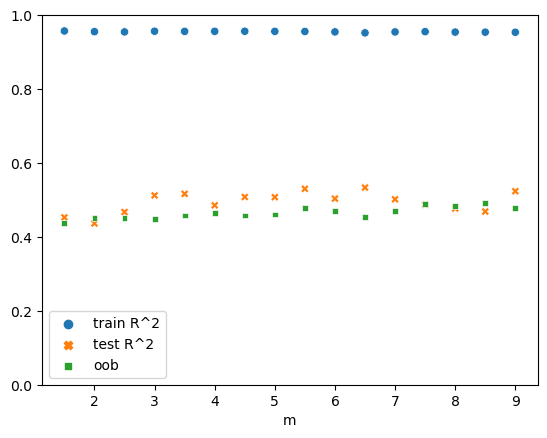

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
f,ax = plt.subplots()
sns.scatterplot(df.set_index('m'),ax=ax)
ax.set_ylim((0,1))
ax.set_xticklabels(range(1,17))
plt.show()